In [2]:
%%javascript
utils.load_extension("collapsible_headings/main")
utils.load_extension("autosavetime/main")
utils.load_extension("execute_time/ExecuteTime")

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from cern_utils import plot_feature_importance
from sklearn.metrics import roc_auc_score,auc
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
plt.style.use('seaborn')

import math

import random 
random.seed(0)

from path_utils import return_impurity,pie_plot_filtered

In [4]:
train = pd.read_csv("train.csv", index_col="Id")
test = pd.read_csv("test.csv", index_col="Id")
train = train.drop(columns="BUTTER")
test = test.drop(columns="BUTTER")

## Feature Engineering

In [5]:
train['train']=1
test['train']=0


In [6]:
df = train.append(test)

In [7]:
df.columns = df.columns.str.replace(' ', '')

In [8]:
df.head()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA,signal,train
Id,,,,,,,,,,,,,,,,
0,28.878847,2.662533,2924.690991,0.999997,19085.568945,0.569198,-0.575502,0.581565,66850.893711,0.637969,14298.486178,7940.694301,2.628526,2.680116,1.0,1
1,34.233566,0.092746,346.948714,0.999997,6631.244546,0.248707,-0.615941,0.277898,39274.475071,0.148815,11553.163934,3904.681337,3.292504,3.085754,1.0,1
2,36.113632,2.442423,238.553023,0.999986,7740.918989,0.222347,0.249383,0.216576,27757.153899,0.249840,24081.196003,4738.891687,3.433676,3.121906,1.0,1
3,14.286133,6.337556,227.375132,0.999806,6740.281614,0.347316,0.591884,0.306927,10593.207077,0.400748,11343.521945,3308.943750,2.291867,2.200712,0.0,1
4,60.474274,7.632751,106.730650,0.999905,5556.388794,0.204273,0.655850,0.196600,11801.249543,0.223101,25940.693317,4026.326871,3.290073,3.281829,0.0,1


In [9]:
df['random'] = np.random.random(df.shape[0])

### Features

In [11]:
# Did not work
df['Kst_892_0_cosThetaH_arc'] = np.arccos(df['Kst_892_0_cosThetaH'])
df['Kst_892_0_cosThetaH_arc_sin'] = np.sin(df.Kst_892_0_cosThetaH_arc)

df['Kplu_pXKst_892costheta'] = df['Kplus_P'] * df['Kst_892_0_cosThetaH']


df['momentum_by_shortest_dist'] = df['Kplus_P']/df['Kplus_IP_OWNPV']

df['momentum_sum'] = df['B_PT'] + df['Kplus_P'] + df['gamma_PT']

In [12]:
# Worked individually
df['Kplu_p_div_Kst_892costheta'] = df['Kplus_P'] / df['Kst_892_0_cosThetaH']

In [13]:
# ETA (estimated time of arrival) inversions -- worked
df['Kplus_ETA_inv'] = 1/df['Kplus_ETA']
df['piminus_ETA_inv'] = 1/df['piminus_ETA']


In [14]:
# Momentum

df['total_mom_2'] = df['B_PT']**2 + df['gamma_PT']**2 + df['Kplus_P']**2
df['total_mom_sum'] = df['B_PT'] + df['gamma_PT']+ df['Kplus_P']

# All mom ratios worked together
df["mom_rat_1"] = df["B_PT"] / df["Kplus_P"]
df["mom_rat_2"] = df["B_PT"] / df["gamma_PT"]


df["mom_rat_3"] = df["gamma_PT"] / df["B_PT"]
df["mom_rat_4"] = df["gamma_PT"] / df["Kplus_P"]

df["mom_rat_5"] = df["Kplus_P"] / df["B_PT"]
df["mom_rat_6"] = df["Kplus_P"] / df["gamma_PT"]

df['ThetaH'] = np.arccos(df['Kst_892_0_cosThetaH'])


df['Kplus_P_x'] = df['Kplus_P'] * np.sin(df['ThetaH'])
df['Kplus_P_y'] = df['Kplus_P'] * np.cos(df['ThetaH'])

df['mom_consev1'] = df["gamma_PT"]**2 + df["Kplus_P"]**2 - df["B_PT"]**2
df['mom_consev1_1'] = ((df["gamma_PT"] + df["Kplus_P"]))**2 - df["B_PT"]**2

In [15]:
# B meson ratios
df['mesB_ratio_1'] = df['B_FDCHI2_OWNPV']/df['B_IPCHI2_OWNPV']
df['mesB_ratio_2'] = df['B_FDCHI2_OWNPV']/df['B_PT']

df['mesB_ratio_3'] = df['B_IPCHI2_OWNPV']/df['B_PT']
df['mesB_ratio_4'] = df['B_IPCHI2_OWNPV']/df['B_PT']

df['mesB_ratio_5'] = df['B_PT']/df['B_IPCHI2_OWNPV']
df['mesB_ratio_6'] = df['B_PT']/df['B_FDCHI2_OWNPV']


In [16]:
# Neither Improved neither worst
df["kst_thetaH"] = np.arccos(df.Kst_892_0_cosThetaH)# * 180 / np.pi
df["kst_thetaH_sin"] = np.sin(df["kst_thetaH"])
df["kst_thetaH_cos"] = np.cos(df["kst_thetaH"])
df["kst_thetaH_sin_cos"] = np.sin(df["kst_thetaH"]) - np.cos(df["kst_thetaH"])
df["kst_thetaH_tan"] = np.tan(df["kst_thetaH"])
df["kst_thetaH_exp"] = np.exp(df["kst_thetaH"])
df["kst_thetaH_exp_1"] = np.exp(-df["kst_thetaH"])


df["B_DIRA_OWNPV_angle"] = np.arccos(df["B_DIRA_OWNPV"])# * 180 / np.pi
df["B_DIRA_OWNPV__cos"] = np.cos(df["B_DIRA_OWNPV_angle"])
df["B_DIRA_OWNPV__sin"] = np.sin(df["B_DIRA_OWNPV_angle"])
df["B_DIRA_OWNPV__tan"] = np.tan(df["B_DIRA_OWNPV_angle"])
df["B_DIRA_OWNPV__sin_cos"] = np.sin(df["B_DIRA_OWNPV_angle"]) - np.cos(
    df["B_DIRA_OWNPV_angle"]
)
df["B_DIRA_OWNPV_exp"] = np.exp(df["B_DIRA_OWNPV_angle"])
df["B_DIRA_OWNPV_exp_1"] = np.exp(-df["B_DIRA_OWNPV_angle"])



In [17]:
# Momentum multiplication
df['mom1_exp'] = df["mom_rat_1"] * df["B_DIRA_OWNPV_exp"] 
df['mom2_exp'] = df["mom_rat_2"] * df["B_DIRA_OWNPV_exp"] 
df['mom3_exp'] = df["mom_rat_3"] * df["B_DIRA_OWNPV_exp"] 
df['mom4_exp'] = df["mom_rat_4"] * df["B_DIRA_OWNPV_exp"] 
df['mom5_exp'] = df["mom_rat_5"] * df["B_DIRA_OWNPV_exp"] 
df['mom6_exp'] = df["mom_rat_6"] * df["B_DIRA_OWNPV_exp"] 
df['mom7_exp'] = df["B_PT"] * df["B_DIRA_OWNPV_exp"] 
df['mom8_exp'] = df["Kplus_P"] * df["B_DIRA_OWNPV_exp"] 
df['mom9_exp'] = df["gamma_PT"] * df["B_DIRA_OWNPV_exp"] 



df['mom11_exp'] = df["mom_rat_1"] * df["kst_thetaH"] 
df['mom22_exp'] = df["mom_rat_2"] * df["kst_thetaH"] 
df['mom33_exp'] = df["mom_rat_3"] * df["kst_thetaH"] 
df['mom44_exp'] = df["mom_rat_4"] * df["kst_thetaH"] 
df['mom55_exp'] = df["mom_rat_5"] * df["kst_thetaH"] 
df['mom66_exp'] = df["mom_rat_6"] * df["kst_thetaH"] 
df['mom77_exp'] = df["B_PT"] * df["kst_thetaH"] 
df['mom88_exp'] = df["Kplus_P"] * df["kst_thetaH"] 
df['mom99_exp'] = df["gamma_PT"] * df["kst_thetaH"] 



df['Kplus_ETA_2'] = df['Kplus_ETA']**2
df['Kplus_ETA_exp'] = np.exp(df['Kplus_ETA'])
df['Kplus_ETA_theta'] = df['Kplus_ETA'] * df["kst_thetaH"]
df['Kplus_ETA_div_theta'] = df['Kplus_ETA'] / df["kst_thetaH"]
df['Kplus_ETA_theta_sin'] = df['Kplus_ETA'] * df["kst_thetaH_sin"]
df['Kplus_ETA_theta_tan'] = df['Kplus_ETA'] * df["kst_thetaH_tan"]

df['piminus_ETA_2'] = df['piminus_ETA']**2
df['piminus_ETA_exp'] = np.exp(df['piminus_ETA'])
df['piminus_ETA_theta'] = df['piminus_ETA'] * df["kst_thetaH"]
df['piminus_ETA_div_theta'] = df['piminus_ETA'] / df["kst_thetaH"]
df['piminus_ETA_theta_sin'] = df['piminus_ETA'] * df["kst_thetaH_sin"]
df['piminus_ETA_theta_tan'] = df['piminus_ETA'] * df["kst_thetaH_tan"]

In [18]:
# Improves
df['Kplus_by_eta'] = df['Kplus_P'] / df['Kplus_ETA']

In [19]:
df['Kplus_piminus_by_eta'] = df['Kplus_P'] / df['piminus_ETA']

In [20]:
df['ETA_add'] = df['Kplus_ETA'] + df['piminus_ETA']
df['ETA_rest'] = df['Kplus_ETA'] - df['piminus_ETA']
df['ETA_mult'] = df['Kplus_ETA'] * df['piminus_ETA']
df['ETA_inv'] = df['Kplus_ETA'] / df['piminus_ETA']
df['ETA_inv1'] = df['piminus_ETA']/df['Kplus_ETA']


In [21]:
df['Kplus_ETA_inv'] = df['Kplus_ETA']
df['piminus_ETA_inv'] = df['piminus_ETA']

In [22]:
df['ETA_add_inv'] = df['Kplus_ETA_inv'] + df['piminus_ETA_inv']
df['ETA_rest_inv'] = df['Kplus_ETA_inv'] - df['piminus_ETA_inv']
df['ETA_mult_inv'] = df['Kplus_ETA_inv'] * df['piminus_ETA_inv']
df['ETA_inv_inv'] = df['Kplus_ETA_inv'] / df['piminus_ETA_inv']
df['ETA_inv1_inv'] = df['piminus_ETA_inv']/df['Kplus_ETA_inv']


In [23]:
df.shape

(354438, 100)

## Splits

In [31]:
train = df[df['train']==1].drop(columns='train')
test = df[df['train']==0].drop(columns='train')

In [32]:
X_tr, X_te, y_tr, y_te = train_test_split(
    train.drop(columns="signal"),
    train.signal,
    stratify=train.signal,
    random_state=0,   train_size=0.99
)

## Catboost

In [34]:
cb = CatBoostClassifier(verbose=0, eval_metric="AUC",# iterations=200,
                        random_seed=0)
cb.fit(X_tr, y_tr)

In [35]:
print("train", roc_auc_score(y_tr.values,cb.predict_proba(X_tr)[:,1]))
print("test", roc_auc_score( y_te,cb.predict_proba(X_te)[:,1]))

train 0.9053296000774367
test 0.8760225431630007


98 features, reduction of 0.00%


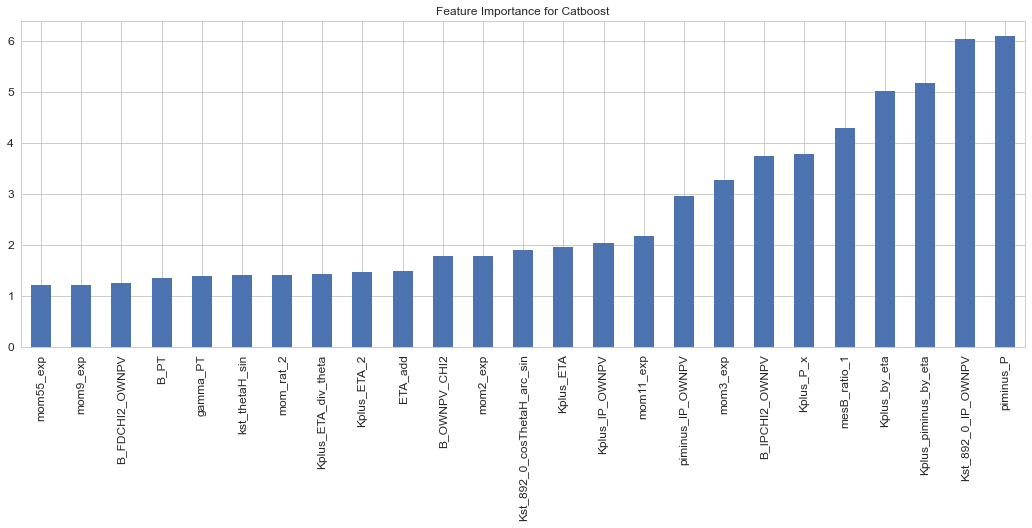

In [36]:
plot_feature_importance(X_tr.columns,cb.get_feature_importance(),columns_ploted=25)

## Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

In [38]:
dt = DecisionTreeClassifier()
dt.fit(X_tr,y_tr)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [44]:
return_impurity(dt, X_tr[X_tr.index == random.choice(X_tr.index)])

,feature,impurity,samples,imp_child,samples_child,impurity_gain,samples_gain
0,mesB_ratio_1,0.444892,210535.0,0.323718,107122.0,28.018184,0.491191
1,Kplus_P_x,0.323718,107122.0,0.397721,65413.0,4.113870,0.198110
2,mesB_ratio_1,0.397721,65413.0,0.455305,39454.0,3.824797,0.123300
3,kst_thetaH_sin,0.455305,39454.0,0.476841,28237.0,2.136955,0.053279
4,Kplus_piminus_by_eta,0.476841,28237.0,0.411325,8292.0,4.775388,0.094735
5,piminus_ETA_2,0.411325,8292.0,0.386666,7154.0,0.306126,0.005405
6,B_DIRA_OWNPV__sin_cos,0.386666,7154.0,0.344694,4518.0,0.574194,0.012520
7,mesB_ratio_1,0.344694,4518.0,0.389240,2471.0,0.282858,0.009723
8,Kplus_ETA_theta,0.389240,2471.0,0.319768,1036.0,0.299490,0.006816
9,Kplus_piminus_by_eta,0.319768,1036.0,0.375778,642.0,0.042763,0.001871


In [45]:
res_g = (
    return_impurity(dt, X_tr[X_tr.index == random.choice(X_tr.index)])
    .groupby("feature", as_index=False)
    .sum()
)
res_g.sort_values('samples_gain',ascending=False)

,feature,impurity,samples,imp_child,samples_child,impurity_gain,samples_gain
10,mesB_ratio_1,1.285871,278584.0,1.268233,147849.0,32.102160,0.620966
6,Kplus_P_x,0.621238,107232.0,0.675499,65521.0,4.115165,0.198119
7,Kplus_piminus_by_eta,0.476841,28237.0,0.411325,8292.0,4.775388,0.094735
9,kst_thetaH_sin,0.455305,39454.0,0.476841,28237.0,2.136955,0.053279
1,B_DIRA_OWNPV__sin_cos,0.386666,7154.0,0.443258,2636.0,0.758913,0.021460
15,piminus_ETA_2,0.909250,8944.0,0.869677,7588.0,0.360759,0.006441
3,B_OWNPV_CHI2,0.489211,1273.0,0.499986,768.0,0.113414,0.002399
0,B_DIRA_OWNPV,0.483011,434.0,0.399755,134.0,0.074125,0.001425
13,mom_consev1_1,0.499986,768.0,0.497925,652.0,0.028186,0.000551
14,piminus_ETA,0.277778,108.0,0.492188,16.0,0.010509,0.000437


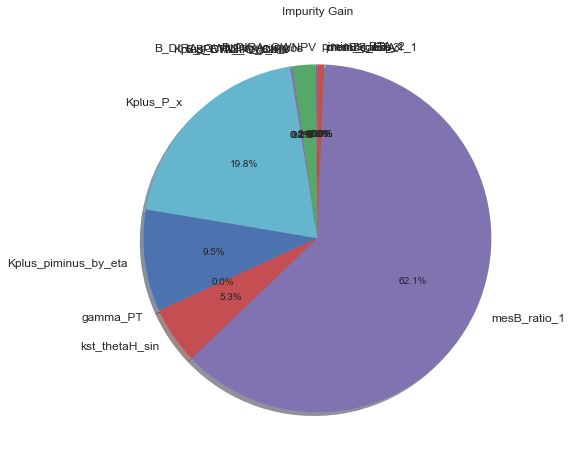

In [46]:

pie_plot_filtered(res_g, "samples_gain", title="Impurity Gain")

In [109]:
kk

NameError: name 'kk' is not defined

In [ ]:
plt.figure()
plot_tree(dt,feature_names=X_tr.columns);
plt.savefig('tree1.eps',format='eps')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_tr,y_tr)

plt.figure()
plot_tree(dt,feature_names=X_tr.columns);
plt.savefig('tree1.eps',format='eps')
plt.show()

## Xgb

In [9]:
xgb = XGBClassifier()
xgb.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
print("train", roc_auc_score(y_tr.values,xgb.predict_proba(X_tr)[:,1]))
print("test", roc_auc_score( y_te,xgb.predict_proba(X_te)[:,1]))

train 0.9040068124561615
test 0.8589757476528211


## Random Forest

In [22]:
rf = RandomForestClassifier(n_estimators=50,min_samples_leaf=10)
rf.fit(X_tr,y_tr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
print("train", roc_auc_score(y_tr.values,rf.predict_proba(X_tr)[:,1]))
print("test", roc_auc_score( y_te,rf.predict_proba(X_te)[:,1]))

train 0.9494586020732473
test 0.8351622265789387


## Voting Classifier

## Own Ensemble

## KNN

In [16]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_tr, y_tr)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [17]:
print("train", roc_auc_score(y_tr.values, knn.predict_proba(X_tr)[:, 1]))
print("test", roc_auc_score(y_te, knn.predict_proba(X_te)[:, 1]))

train 0.8311094479804438
test 0.746261194549087


## Submission

In [47]:
test['Predicted'] = cb.predict_proba(test)[:,1]

In [48]:
test[['Predicted']].to_csv('submissions/cb_feat1.csv')